# 匯入套件

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm

from torchsummary import summary

In [2]:
# 檢查是否有可用的GPU，如果沒有，則使用CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) # 印出目前使用的設備

cuda


# 資料預處理

In [3]:
# 定義影像的轉換操作
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 將影像大小統一調整為256x256
    transforms.Grayscale(num_output_channels=1),  # 轉換為單通道灰度影像
    transforms.ToTensor(),           # 將影像轉換為PyTorch張量
    transforms.Normalize(mean=[0.485], std=[0.229]),  # 影像正規化
])

# 載入資料集

In [4]:
# 載入訓練集
train_dataset = datasets.ImageFolder(root='chest_xray/train/', transform=transform)
# 訓練集的平均值和標準差
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 載入驗證集
val_dataset = datasets.ImageFolder(root='chest_xray/val/', transform=transform)
# 驗證集的平均值和標準差
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 載入測試集
test_dataset = datasets.ImageFolder(root='chest_xray/test/', transform=transform)
# 測試集的平均值和標準差
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 建立模型

In [5]:
# 定義一個卷積神經網路
class CNN(nn.Module):
    def __init__(self): # 定義初始化方法
        super(CNN, self).__init__() # 繼承父類別的初始化方法
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 第一個卷積層
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 第二個卷積層
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 第三個卷積層
        self.pool = nn.MaxPool2d(2, 2)                            # 池化層
        self.adap_pool = nn.AdaptiveAvgPool2d((1, 1))             # 自適應池化層
        self.fc1 = nn.Linear(128, 512)                            # 全連接層
        self.fc2 = nn.Linear(512, 2)                              # 輸出層

    # 定義向前傳播函數，x為輸入的影像張量
    def forward(self, x):
        x = F.relu(self.conv1(x)) # 使用ReLU激活函數
        x = self.pool(x)         # 池化
        x = F.relu(self.conv2(x)) # 使用ReLU激活函數
        x = self.pool(x)        # 池化
        x = F.relu(self.conv3(x)) # 使用ReLU激活函數
        x = self.pool(x)       # 池化
        x = self.adap_pool(x)  # 自適應池化層將任何尺寸的特徵圖調整為1x1
        x = x.view(-1, 128)    # 攤平特徵圖
        x = F.relu(self.fc1(x)) # 使用ReLU激活函數
        x = self.fc2(x)        # 輸出層
        return x              # 返回輸出

# 建立一個卷積神經網路的實例
model = CNN()

In [6]:
model.to(device) # 將模型移到目前使用的設備上

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adap_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

# 查看模型架構

In [7]:
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
         MaxPool2d-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
         MaxPool2d-6          [-1, 128, 32, 32]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Linear-8                  [-1, 512]          66,048
            Linear-9                    [-1, 2]           1,026
Total params: 159,746
Trainable params: 159,746
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 35.00
Params size (MB): 0.61
Estimated Total Size (MB): 35.86
-----------------------------------------

# 訓練模型

In [8]:
# 設定損失函數和優化器
criterion = nn.CrossEntropyLoss()
# 使用Adam優化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 設定epoch數量
num_epochs = 100

# 準備記錄損失和準確率
train_losses = []  # 用於儲存每個epoch的訓練損失
val_losses = []    # 用於儲存每個epoch的驗證損失
val_accuracies = []  # 用於儲存每個epoch的驗證準確率

# 訓練模型
for epoch in range(num_epochs):
    model.train()  # 設定模型為訓練模式
    running_loss = 0.0 # 用於累積訓練損失
    train_correct = 0 # 用於累積訓練準確率
    train_total = 0  # 用於累積訓練資料的總數

    # 使用tqdm進度條展示訓練進度
    train_loop = tqdm(train_loader, position=0, leave=True) # 建立一個用於訓練的迴圈
    for images, labels in train_loop: # 迭代訓練資料集
        images, labels = images.to(device), labels.to(device)  # 將資料移到GPU上

        # 前向傳播
        outputs = model(images)
        loss = criterion(outputs, labels)  # 計算損失

        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward() # 計算梯度
        optimizer.step() # 更新權重

        running_loss += loss.item() # 累積訓練損失
        _, predicted = torch.max(outputs.data, 1) # 預測類別
        train_total += labels.size(0) # 累積訓練資料的總數
        train_correct += (predicted == labels).sum().item() # 累積訓練準確率

        # 更新進度條的顯示
        train_loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        # 顯示當前的訓練損失和準確率
        train_loop.set_postfix(loss=running_loss/train_total, accuracy=100. * train_correct / train_total)

    # 計算本輪的平均訓練損失
    train_losses.append(running_loss / len(train_loader))
    # 計算本輪的平均訓練準確率
    train_accuracy = 100. * train_correct / train_total

    # 驗證階段
    model.eval()  # 設定模型為評估模式
    val_running_loss = 0.0 # 用於累積驗證損失
    val_correct = 0 # 用於累積驗證準確率
    val_total = 0 # 用於累積驗證資料的總數
    with torch.no_grad(): # 不計算梯度
        for images, labels in val_loader: # 迭代驗證資料集
            images, labels = images.to(device), labels.to(device) # 將資料移到GPU上
            outputs = model(images) # 前向傳播
            loss = criterion(outputs, labels) # 計算損失
            val_running_loss += loss.item() # 累積驗證損失
            _, predicted = torch.max(outputs.data, 1) # 預測類別
            val_total += labels.size(0) # 累積驗證資料的總數
            val_correct += (predicted == labels).sum().item() # 累積驗證準確率

    # 計算本輪的平均驗證損失
    val_losses.append(val_running_loss / len(val_loader))
    # 計算本輪的平均驗證準確率
    val_accuracy = 100 * val_correct / val_total
    # 紀錄本輪的驗證準確率
    val_accuracies.append(val_accuracy)

    # 顯示本輪的訓練和驗證損失以及驗證準確率
    print(f'Validation Accuracy: {val_accuracy}%')

# 儲存訓練好的模型參數
torch.save(model.state_dict(), 'pneumonia_model.pth')


Epoch [1/100]: 100%|█████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=74.1, loss=0.0176]


Validation Accuracy: 56.25%


Epoch [2/100]: 100%|█████████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=78.6, loss=0.0134]


Validation Accuracy: 50.0%


Epoch [3/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=87.9, loss=0.00886]


Validation Accuracy: 50.0%


Epoch [4/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=90.3, loss=0.00754]


Validation Accuracy: 50.0%


Epoch [5/100]: 100%|█████████████████████████████████████| 163/163 [01:12<00:00,  2.24it/s, accuracy=91.2, loss=0.0067]


Validation Accuracy: 50.0%


Epoch [6/100]: 100%|█████████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=92.8, loss=0.0058]


Validation Accuracy: 50.0%


Epoch [7/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=93.5, loss=0.00526]


Validation Accuracy: 56.25%


Epoch [8/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=94.2, loss=0.00468]


Validation Accuracy: 50.0%


Epoch [9/100]: 100%|██████████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=95, loss=0.00415]


Validation Accuracy: 56.25%


Epoch [10/100]: 100%|█████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=95, loss=0.00403]


Validation Accuracy: 81.25%


Epoch [11/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=95.5, loss=0.00381]


Validation Accuracy: 75.0%


Epoch [12/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=95.8, loss=0.00348]


Validation Accuracy: 68.75%


Epoch [13/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=95.5, loss=0.00356]


Validation Accuracy: 87.5%


Epoch [14/100]: 100%|███████████████████████████████████| 163/163 [01:11<00:00,  2.26it/s, accuracy=95.6, loss=0.00355]


Validation Accuracy: 62.5%


Epoch [15/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=96.2, loss=0.00318]


Validation Accuracy: 56.25%


Epoch [16/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=95.8, loss=0.00323]


Validation Accuracy: 56.25%


Epoch [17/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=96.2, loss=0.00313]


Validation Accuracy: 75.0%


Epoch [18/100]: 100%|█████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=96, loss=0.00344]


Validation Accuracy: 87.5%


Epoch [19/100]: 100%|█████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=97, loss=0.00267]


Validation Accuracy: 75.0%


Epoch [20/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=96.9, loss=0.00274]


Validation Accuracy: 81.25%


Epoch [21/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=96.6, loss=0.00279]


Validation Accuracy: 81.25%


Epoch [22/100]: 100%|███████████████████████████████████| 163/163 [01:13<00:00,  2.23it/s, accuracy=97.2, loss=0.00236]


Validation Accuracy: 75.0%


Epoch [23/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.24it/s, accuracy=97.3, loss=0.00249]


Validation Accuracy: 75.0%


Epoch [24/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=97.6, loss=0.00224]


Validation Accuracy: 81.25%


Epoch [25/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=97.1, loss=0.00241]


Validation Accuracy: 87.5%


Epoch [26/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=97.4, loss=0.00213]


Validation Accuracy: 81.25%


Epoch [27/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=97.5, loss=0.00205]


Validation Accuracy: 81.25%


Epoch [28/100]: 100%|███████████████████████████████████| 163/163 [01:13<00:00,  2.23it/s, accuracy=97.7, loss=0.00207]


Validation Accuracy: 68.75%


Epoch [29/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.24it/s, accuracy=97.6, loss=0.00201]


Validation Accuracy: 81.25%


Epoch [30/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.24it/s, accuracy=97.2, loss=0.00227]


Validation Accuracy: 93.75%


Epoch [31/100]: 100%|██████████████████████████████████████| 163/163 [01:12<00:00,  2.24it/s, accuracy=98, loss=0.0018]


Validation Accuracy: 100.0%


Epoch [32/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=98.1, loss=0.00151]


Validation Accuracy: 81.25%


Epoch [33/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=97.9, loss=0.00171]


Validation Accuracy: 81.25%


Epoch [34/100]: 100%|█████████████████████████████████████| 163/163 [01:11<00:00,  2.28it/s, accuracy=98, loss=0.00148]


Validation Accuracy: 93.75%


Epoch [35/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=98.3, loss=0.00149]


Validation Accuracy: 93.75%


Epoch [36/100]: 100%|██████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=98, loss=0.0017]


Validation Accuracy: 93.75%


Epoch [37/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=97.8, loss=0.00171]


Validation Accuracy: 87.5%


Epoch [38/100]: 100%|███████████████████████████████████| 163/163 [01:11<00:00,  2.26it/s, accuracy=98.5, loss=0.00132]


Validation Accuracy: 75.0%


Epoch [39/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=98.5, loss=0.00139]


Validation Accuracy: 93.75%


Epoch [40/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=98.7, loss=0.00114]


Validation Accuracy: 87.5%


Epoch [41/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=98.7, loss=0.00115]


Validation Accuracy: 93.75%


Epoch [42/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=98.4, loss=0.00133]


Validation Accuracy: 87.5%


Epoch [43/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=98.5, loss=0.00122]


Validation Accuracy: 87.5%


Epoch [44/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=98.6, loss=0.00117]


Validation Accuracy: 93.75%


Epoch [45/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=98.8, loss=0.00115]


Validation Accuracy: 87.5%


Epoch [46/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.2, loss=0.00082]


Validation Accuracy: 100.0%


Epoch [47/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=98.8, loss=0.00101]


Validation Accuracy: 93.75%


Epoch [48/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.1, loss=0.000862]


Validation Accuracy: 100.0%


Epoch [49/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=98.6, loss=0.00128]


Validation Accuracy: 100.0%


Epoch [50/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.24it/s, accuracy=99.2, loss=0.000731]


Validation Accuracy: 100.0%


Epoch [51/100]: 100%|█████████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=99, loss=0.00078]


Validation Accuracy: 100.0%


Epoch [52/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.24it/s, accuracy=99.2, loss=0.000674]


Validation Accuracy: 100.0%


Epoch [53/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=98.6, loss=0.00117]


Validation Accuracy: 100.0%


Epoch [54/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.1, loss=0.000743]


Validation Accuracy: 93.75%


Epoch [55/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=99.4, loss=0.000562]


Validation Accuracy: 93.75%


Epoch [56/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.1, loss=0.000797]


Validation Accuracy: 81.25%


Epoch [57/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=99.3, loss=0.000674]


Validation Accuracy: 93.75%


Epoch [58/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=98.9, loss=0.000904]


Validation Accuracy: 93.75%


Epoch [59/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=98.3, loss=0.00142]


Validation Accuracy: 87.5%


Epoch [60/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.4, loss=0.000542]


Validation Accuracy: 93.75%


Epoch [61/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.6, loss=0.000362]


Validation Accuracy: 100.0%


Epoch [62/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.4, loss=0.000451]


Validation Accuracy: 93.75%


Epoch [63/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.8, loss=0.000304]


Validation Accuracy: 93.75%


Epoch [64/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.2, loss=0.000696]


Validation Accuracy: 93.75%


Epoch [65/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.3, loss=0.000686]


Validation Accuracy: 93.75%


Epoch [66/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.5, loss=0.000441]


Validation Accuracy: 93.75%


Epoch [67/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.6, loss=0.000374]


Validation Accuracy: 93.75%


Epoch [68/100]: 100%|███████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.8, loss=0.00029]


Validation Accuracy: 93.75%


Epoch [69/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.6, loss=0.000356]


Validation Accuracy: 93.75%


Epoch [70/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.26it/s, accuracy=99.9, loss=0.000189]


Validation Accuracy: 93.75%


Epoch [71/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.8, loss=0.000229]


Validation Accuracy: 100.0%


Epoch [72/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.1, loss=0.000714]


Validation Accuracy: 93.75%


Epoch [73/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.4, loss=0.000497]


Validation Accuracy: 81.25%


Epoch [74/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=98.5, loss=0.00129]


Validation Accuracy: 100.0%


Epoch [75/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.26it/s, accuracy=99.9, loss=0.000202]


Validation Accuracy: 93.75%


Epoch [76/100]: 100%|████████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=100, loss=0.00012]


Validation Accuracy: 93.75%


Epoch [77/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.9, loss=0.000136]


Validation Accuracy: 93.75%


Epoch [78/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.9, loss=0.000166]


Validation Accuracy: 100.0%


Epoch [79/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.7, loss=0.000288]


Validation Accuracy: 100.0%


Epoch [80/100]: 100%|███████████████████████████████████| 163/163 [01:11<00:00,  2.26it/s, accuracy=98.8, loss=0.00119]


Validation Accuracy: 93.75%


Epoch [81/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.2, loss=0.000608]


Validation Accuracy: 100.0%


Epoch [82/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.9, loss=0.000199]


Validation Accuracy: 100.0%


Epoch [83/100]: 100%|██████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=99.8, loss=0.000187]


Validation Accuracy: 87.5%


Epoch [84/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.7, loss=0.000328]


Validation Accuracy: 100.0%


Epoch [85/100]: 100%|██████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=99.8, loss=0.000216]


Validation Accuracy: 93.75%


Epoch [86/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=99.9, loss=8.2e-5]


Validation Accuracy: 100.0%


Epoch [87/100]: 100%|████████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=100, loss=2.22e-5]


Validation Accuracy: 93.75%


Epoch [88/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=100, loss=1.33e-5]


Validation Accuracy: 93.75%


Epoch [89/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=100, loss=1.52e-5]


Validation Accuracy: 93.75%


Epoch [90/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=100, loss=2.29e-5]


Validation Accuracy: 93.75%


Epoch [91/100]: 100%|████████████████████████████████████| 163/163 [01:11<00:00,  2.26it/s, accuracy=100, loss=1.42e-5]


Validation Accuracy: 93.75%


Epoch [92/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=100, loss=6.34e-6]


Validation Accuracy: 93.75%


Epoch [93/100]: 100%|████████████████████████████████████| 163/163 [01:11<00:00,  2.27it/s, accuracy=100, loss=5.02e-6]


Validation Accuracy: 93.75%


Epoch [94/100]: 100%|████████████████████████████████████| 163/163 [01:11<00:00,  2.26it/s, accuracy=100, loss=4.19e-6]


Validation Accuracy: 93.75%


Epoch [95/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=100, loss=3.82e-6]


Validation Accuracy: 93.75%


Epoch [96/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=100, loss=3.17e-6]


Validation Accuracy: 93.75%


Epoch [97/100]: 100%|█████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=100, loss=2.9e-6]


Validation Accuracy: 93.75%


Epoch [98/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=100, loss=2.66e-6]


Validation Accuracy: 93.75%


Epoch [99/100]: 100%|████████████████████████████████████| 163/163 [01:12<00:00,  2.26it/s, accuracy=100, loss=2.39e-6]


Validation Accuracy: 93.75%


Epoch [100/100]: 100%|███████████████████████████████████| 163/163 [01:12<00:00,  2.25it/s, accuracy=100, loss=2.18e-6]


Validation Accuracy: 93.75%


# 可視化訓練結果

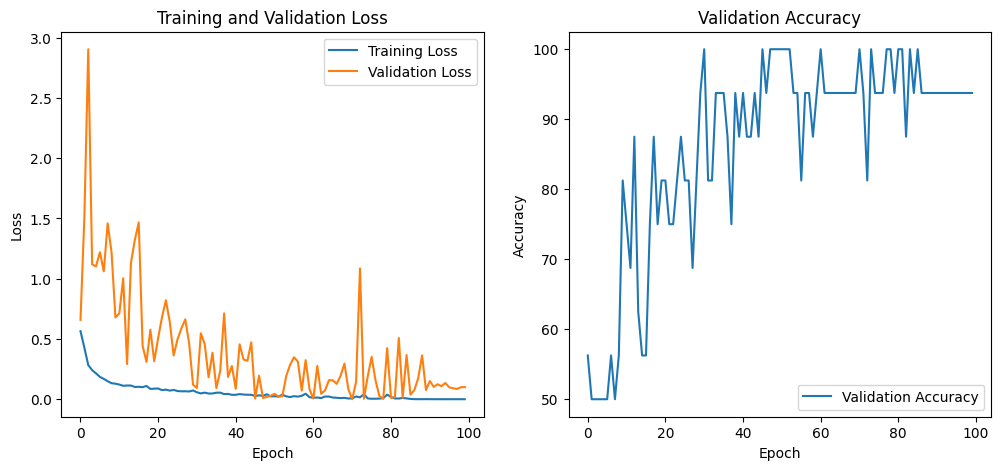

In [9]:
# 可視化訓練和驗證損失
plt.figure(figsize=(12, 5)) # 設定圖形大小
plt.subplot(1, 2, 1) # 建立子圖形1
plt.plot(train_losses, label='Training Loss') # 繪製訓練損失
plt.plot(val_losses, label='Validation Loss') # 繪製驗證損失
plt.title('Training and Validation Loss') # 設定圖形標題
plt.xlabel('Epoch') # 設定x軸標籤
plt.ylabel('Loss') # 設定y軸標籤
plt.legend() # 顯示圖例

# 可視化驗證準確率
plt.subplot(1, 2, 2) # 建立子圖形2
plt.plot(val_accuracies, label='Validation Accuracy') # 繪製驗證準確率
plt.title('Validation Accuracy') # 設定圖形標題
plt.xlabel('Epoch') # 設定x軸標籤
plt.ylabel('Accuracy') # 設定y軸標籤
plt.legend() # 顯示圖例

plt.show() # 顯示圖形

# 混淆矩陣、靈敏度和特異度

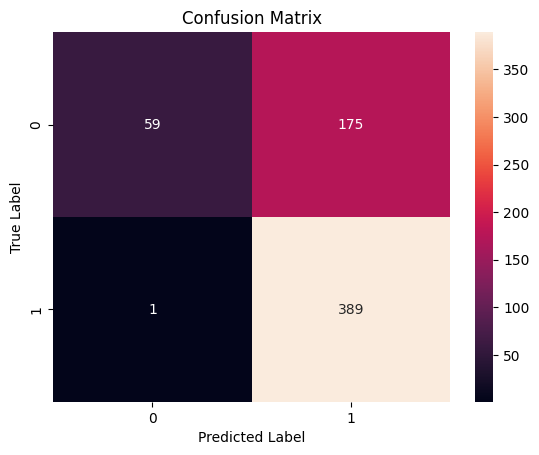

Sensitivity: 0.9974358974358974
Specificity: 0.25213675213675213


In [10]:
model.eval() # 設定模型為評估模式
y_true = [] # 用於儲存真實標籤
y_pred = [] # 用於儲存預測標籤

# 不計算梯度
with torch.no_grad():
    for images, labels in test_loader: # 迭代測試資料集
        images, labels = images.to(device), labels.to(device) # 將資料移到GPU上
        outputs = model(images) # 前向傳播
        _, predicted = torch.max(outputs.data, 1) # 預測類別
        y_true.extend(labels.cpu().numpy()) # 儲存真實標籤
        y_pred.extend(predicted.cpu().numpy()) # 儲存預測標籤

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_true, y_pred)

# 計算靈敏度和特異度
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn) # 計算靈敏度
specificity = tn / (tn + fp) # 計算特異度

# 可視化混淆矩陣
sns.heatmap(conf_matrix, annot=True, fmt='d') # 繪製混淆矩陣
plt.title('Confusion Matrix') # 設定圖形標題
plt.ylabel('True Label') # 設定y軸標籤
plt.xlabel('Predicted Label') # 設定x軸標籤
plt.show() # 顯示圖形

print(f'Sensitivity: {sensitivity}') # 顯示靈敏度
print(f'Specificity: {specificity}') # 顯示特異度

# AUC曲線

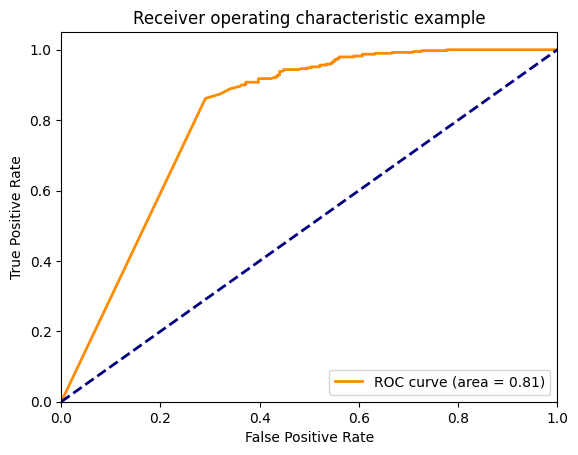

In [11]:
# 模型評估模式
model.eval()

# 儲存所有標籤和模型預測的機率
all_labels = []
# 由於模型輸出的是對數機率，因此需要使用softmax函數轉換為機率
all_probs = []

# 不計算梯度
with torch.no_grad():
    for images, labels in test_loader: # 迭代測試資料集
        images, labels = images.to(device), labels.to(device) # 將資料移到GPU上
        
        # 取得模型的預測機率
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1) # 使用softmax函數轉換為機率
        
        all_probs.extend(probabilities.cpu().numpy()) # 儲存預測機率
        all_labels.extend(labels.cpu().numpy()) # 儲存標籤

# 計算每個類別的機率
all_probs = np.array(all_probs)
# 由於是二分類，取第一個類別的機率
all_labels = np.array(all_labels)

# 由於是二分類，取第一個類別的機率
# 注意：如果您的類別標籤不是 {0, 1}，則需要相應調整
prob_of_pos_class = all_probs[:, 1]

# 計算 ROC 曲線
fpr, tpr, thresholds = roc_curve(all_labels, prob_of_pos_class, pos_label=1)

# 計算 AUC
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure() # 建立圖形
lw = 2 # 設定線寬
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) # 繪製 ROC 曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # 繪製對角線
plt.xlim([0.0, 1.0]) # 設定x軸範圍
plt.ylim([0.0, 1.05]) # 設定y軸範圍
plt.xlabel('False Positive Rate') # 設定x軸標籤
plt.ylabel('True Positive Rate') # 設定y軸標籤
plt.title('Receiver operating characteristic example') # 設定圖形標題
plt.legend(loc="lower right") # 顯示圖例
plt.show() # 顯示圖形


# F1 score

In [12]:
# 確保模型處於評估模式
model.eval()

# 儲存預測和真實標籤
all_preds = []
all_labels = []

# 無需計算梯度
with torch.no_grad():
    for images, labels in test_loader: # 迭代測試資料集
        images, labels = images.to(device), labels.to(device) # 將資料移到GPU上

        # 取得模型預測
        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # 預測類別

        # 收集預測和真實標籤
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 計算分類報告
report = classification_report(all_labels, all_preds, output_dict=True)

# 轉換為 DataFrame
report_df = pd.DataFrame(report).transpose()

# 將分類報告以文字表格形式顯示
print(report_df)


              precision    recall  f1-score     support
0              0.983333  0.252137  0.401361  234.000000
1              0.689716  0.997436  0.815514  390.000000
accuracy       0.717949  0.717949  0.717949    0.717949
macro avg      0.836525  0.624786  0.608437  624.000000
weighted avg   0.799823  0.717949  0.660206  624.000000
